# XGBoost

## Importing the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
import optuna

In [ ]:
!pip install optuna

## Importing the dataset

In [ ]:
dataset = pd.read_excel('Data_10s_summary_icurve_noitae.xlsx')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

print(dataset)



       P     I           IAE           ISE          OS     STATUS
0    0.0   0.4  1.319288e+17  1.393534e+33   14.497201  AGRESSIVE
1    0.0   0.8  3.912662e+08  4.766471e+15    0.000000  AGRESSIVE
2    0.0   1.2  1.695893e+05  4.557204e+08   39.411180  AGRESSIVE
3    0.0   1.6  3.597283e+03  8.184215e+04   84.020967  AGRESSIVE
4    0.0   2.0  5.898912e+02  1.458826e+03  305.966746  AGRESSIVE
..   ...   ...           ...           ...         ...        ...
620  6.0   8.4  3.700473e+01  5.538796e+01   47.970562   SLUGGISH
621  6.0   8.8  3.801564e+01  5.550805e+01   47.786869   SLUGGISH
622  6.0   9.2  3.903367e+01  5.564539e+01   47.623959   SLUGGISH
623  6.0   9.6  4.005747e+01  5.579219e+01   47.479702   SLUGGISH
624  6.0  10.0  4.108441e+01  5.594762e+01   47.352272   SLUGGISH

[625 rows x 6 columns]


## Splitting the dataset into the Training set and Test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0,stratify = y)


print(X_test)



from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

from tabulate import tabulate
y_test = le.fit_transform(y_test)



In [ ]:
def objective(trial,data=data,target=target):
    
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBClassifier(**param)  
    
    model.fit(X_train,y_train_y,eval_set=[(X_test,y_test)],early_stopping_rounds=10,verbose=False)
    
    preds = model.predict(X_test)
    
    scoring = 'roc_auc'
    
    return scoring

## Training XGBoost on the Training set

In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.001,
              learning_rate=1, max_delta_step=5, max_depth=3,
              min_child_weight=1, n_estimators=150, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=8.6, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)
classifier.fit(X_train, y_train)

[13:51:21] WARNING: ../src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:51:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=5, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=8.6, scale_pos_weight=1, seed=42, silent=None,
              subsample=1, tree_method='exact', use_label_encoder=True,
              validate_parameters=1, ...)

## Making the Confusion Matrix

[[55  0  1]
 [ 0 18  0]
 [ 0  0 51]]
<function confusion_matrix at 0x7f8dcd394a70>
<function confusion_matrix at 0x7f8dcd394a70>


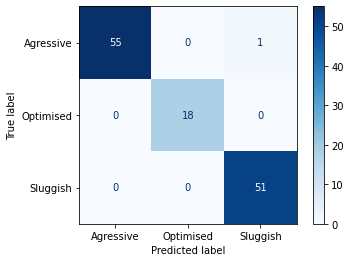

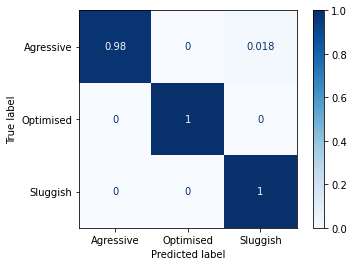

99.2 %


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix


y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)


titles_options = [("Confusion Matrix", None),
                    ("Normalised Confusion Matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier,
                      X_test,
                      y_test,
                      cmap=plt.cm.Blues,
                      display_labels=["Agressive","Optimised","Sluggish"],
                    normalize=normalize)


    print(confusion_matrix)
plt.show()
print(accuracy_score(y_test, y_pred)*100,"%")




## Applying k-Fold Cross Validation

In [ ]:

accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 5)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier,
                      X_train,
                      y_train,
                      cmap=plt.cm.Blues,
                      display_labels=["Agressive","Optimised","Sluggish"],
                    normalize=normalize)

    disp.ax_.set_title(title)
    print(title)
    print(confusion_matrix)
plt.show()